In [54]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd

In [55]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [56]:
tf.test.is_built_with_gpu_support()

True

In [57]:
#DATASET SELECTION SECTION. UNCOMMENT THE DATASETS TO BE USED (REMOVE THE #) 

#data1 = 'simulated_data_sep_var_100_800k_novdesv.csv'
#data2 = 'simulated_data_sep_var_100_800k_novdesv_2.csv'
#data1 = 'simulated_data_sep_var_150_800k_novdesv.csv'
#data2 = 'simulated_data_sep_var_150_800k_novdesv_2.csv'
data1 = 'simulated_data_sep_var_50_800k_novdesv.csv'
#data2 = 'simulated_data_sep_var_50_800k_novdesv_2.csv'
time = 1

In [58]:
dataset1 = pd.read_csv(f'./Simulations/{data1}', header=0, index_col=0, sep = ';')
#dataset2 = pd.read_csv(f'./Simulations/{data2}, header=0, index_col=0, sep = ';') #COMMENT (ADD #) IF ONLY 800K SECONDS USED
#dataset = pd.concat([dataset1,dataset2],ignore_index=True) #COMMENT IF USING 1 DATASET (800K SECONDS)
dataset = dataset1  ## COMMENT IF USING 2 DATASETS (1.6 MILLION SECONDS)
values = dataset.values
values

array([[25.0075091 , 69.98262207, 10.00829707, 54.20282996],
       [25.02046209, 69.99597894, 10.00119401, 54.20211761],
       [24.9828642 , 69.98555891, 10.00194379, 54.186973  ],
       ...,
       [25.48100859, 75.00039373, 12.83510324, 55.93047515],
       [25.45860545, 74.99359481, 12.83101851, 55.93377794],
       [25.4981747 , 75.01080619, 12.83503997, 55.93715282]])

In [59]:
n = len(dataset)
n

800000

In [60]:
a = dataset.describe()
a.to_clipboard()

In [61]:
column_indices = {name: i for i, name in enumerate(dataset.columns)}
n = len(dataset)
train_df = dataset[0:time*int(n*0.7)]
val_df = dataset[time*int(n*0.7):time*int(n*0.9)]
test_df = dataset[time*int(n*0.9):]
num_features = dataset.shape[1]
num_features

4

In [62]:
n

800000

In [63]:
train_mean = train_df.mean()
train_std = train_df.std()


In [64]:
train_mean

Outer Temp.            25.041515
Initial Inner Temp.    69.902352
Outer Ws               10.039647
Inner Temp.            55.038887
dtype: float64

In [65]:
train_std

Outer Temp.            2.929728
Initial Inner Temp.    5.753829
Outer Ws               5.711073
Inner Temp.            4.768334
dtype: float64

In [66]:
train_df

,Outer Temp.,Initial Inner Temp.,Outer Ws,Inner Temp.
0.25,25.007509,69.982622,10.008297,54.202830
1.25,25.020462,69.995979,10.001194,54.202118
2.25,24.982864,69.985559,10.001944,54.186973
3.25,24.997971,69.995884,10.005157,54.221797
4.25,25.017789,69.996538,10.009373,54.217650
...,...,...,...,...
559995.25,29.717885,78.265719,5.674056,63.261275
559996.25,29.694693,78.257510,5.685929,63.285908
559997.25,29.719792,78.262762,5.674237,63.277017
559998.25,29.698226,78.255168,5.675991,63.273067


In [67]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


In [68]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [69]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)


  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [70]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=128,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [71]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = next(iter(self.val))
  self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [72]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [73]:
val_performance = {}
performance = {}

In [74]:
MAX_EPOCHS = 15

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanAbsoluteError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [75]:
OUT_STEPS = 60
multi_window = WindowGenerator(input_width=90,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['Inner Temp.'])

In [76]:
def plot(self, model=None, plot_col='Inner Temp.', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 80))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [s]')

WindowGenerator.plot = plot

In [77]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(150, return_sequences=False),
    
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])
history = compile_and_fit(multi_lstm_model, multi_window)
1

multi_val_performance = multi_lstm_model.evaluate(multi_window.val)
multi_performance = multi_lstm_model.evaluate(multi_window.test, verbose=0)
#multi_window.plot(multi_lstm_model)

Epoch 1/15
4374/4374 [==============================] - 40s 9ms/step - loss: 0.0796 - mean_absolute_error: 0.0796 - val_loss: 0.0656 - val_mean_absolute_error: 0.0656
Epoch 2/15
4374/4374 [==============================] - 39s 9ms/step - loss: 0.0635 - mean_absolute_error: 0.0635 - val_loss: 0.0634 - val_mean_absolute_error: 0.0634
Epoch 3/15
4374/4374 [==============================] - 37s 9ms/step - loss: 0.0617 - mean_absolute_error: 0.0617 - val_loss: 0.0647 - val_mean_absolute_error: 0.0647
Epoch 4/15
4374/4374 [==============================] - 38s 9ms/step - loss: 0.0607 - mean_absolute_error: 0.0607 - val_loss: 0.0607 - val_mean_absolute_error: 0.0607
Epoch 5/15
4374/4374 [==============================] - 38s 9ms/step - loss: 0.0601 - mean_absolute_error: 0.0601 - val_loss: 0.0602 - val_mean_absolute_error: 0.0602
Epoch 6/15
4374/4374 [==============================] - 39s 9ms/step - loss: 0.0596 - mean_absolute_error: 0.0596 - val_loss: 0.0610 - val_mean_absolute_error: 0.061

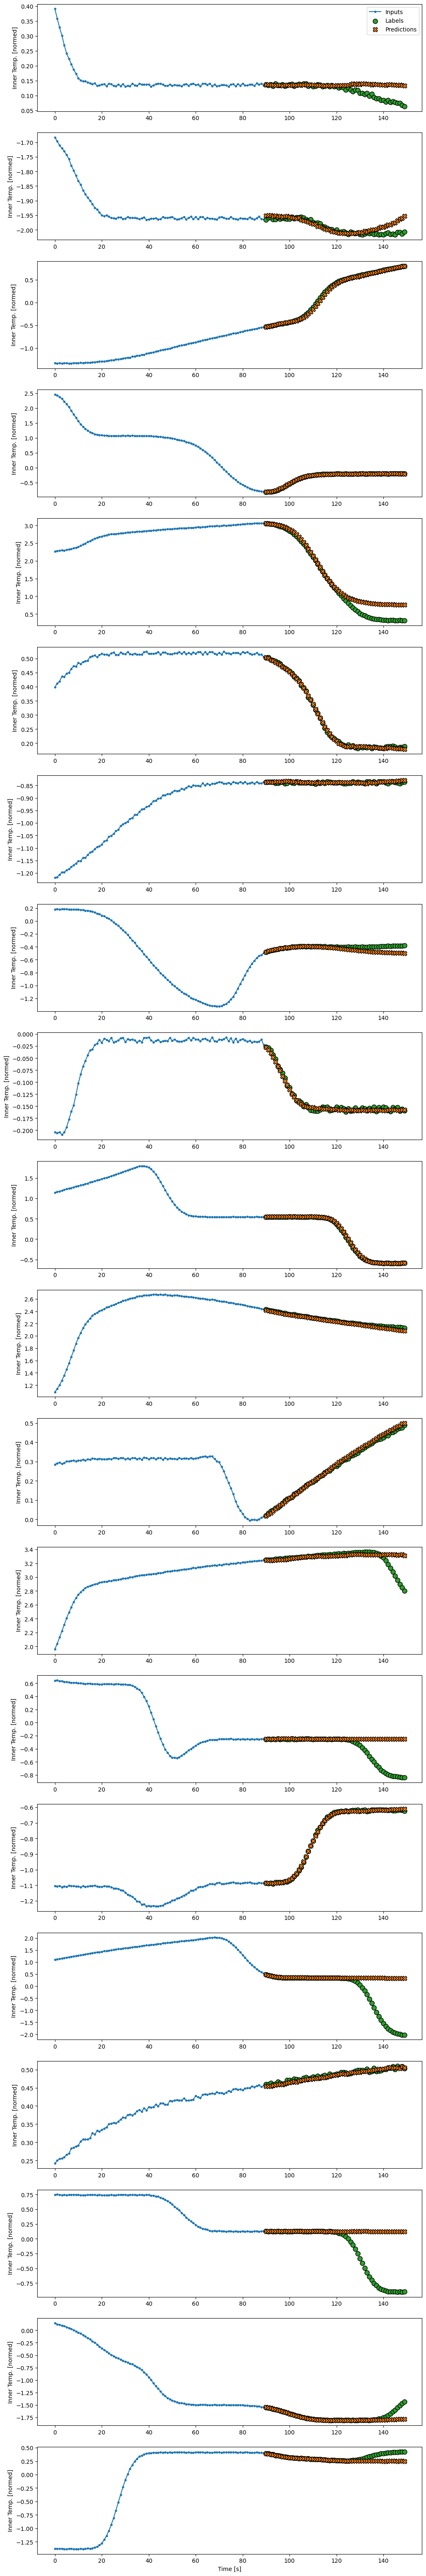

In [78]:
multi_window.plot(multi_lstm_model, max_subplots= 20)

In [81]:
#UNCOMMENT TO SAVE THE MODEL

#multi_lstm_model.save('m60_n90_s150_i50_l1600k/my_model',save_format = 'h5')